# Data assimilation example

This notebook is an example of data assimilation on eddies. It uses the file classes.py, eddy_prediction.py and plot.py of the project (https://github.com/lordastorios/Projet_3A_IMTA).

Autors: G. Ghienne, **A. Lefebvre, A. Lerosey, L. Menard, A. Perier.**

Note that the project use the AnDA library attached to the publication "The Analog Data Assimilation", from **R. Lguensat, P. Tandeo, and others**, submitted to the *Monthly Weather Review*.

## Initialization

We first initialize our environnement and do usefull import

In [1]:
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings("ignore")

from eddies_prediction import create_catalog,calculate_B,predict_eddy,get_eddy,create_observation
from plot import StreamPlot

import matplotlib.pyplot as plt
import pandas as pd
from time import time
import numpy as np

We now define a catalog as well as some future observation from a 'catalog.csv file' (see Eddies_path.pynb).

In [2]:
dt_frame_eddies = pd.read_csv("catalog.csv",usecols=list(range(1,9)))

present_time=80
catalog_eddies = dt_frame_eddies[dt_frame_eddies.date<80]
observation_eddies = dt_frame_eddies[dt_frame_eddies.date>=80]

In [3]:
catalog_eddies

,date,id,center_x,center_y,a,b,angle,omega
0,0,1,55.182947,15.765710,0.996490,0.917343,0.359370,-0.000003
1,0,2,57.663832,16.462744,0.352356,0.901428,-2.984302,0.000004
2,1,1,55.198971,15.686171,1.061340,0.928108,0.556703,-0.000004
3,1,2,57.583567,16.511366,0.392029,0.786621,-3.020211,0.000005
4,2,1,55.053229,15.625271,1.156326,0.942291,0.322667,-0.000004
...,...,...,...,...,...,...,...,...
161,77,11,56.577554,14.748894,0.565765,0.882141,3.135939,-0.000003
162,77,14,53.950322,14.728423,0.577026,1.084686,-2.848391,0.000003
163,78,11,56.605443,14.736110,0.581100,0.975006,3.029069,-0.000003
164,79,11,56.468997,14.341965,0.673645,0.767303,3.010980,-0.000004


In [4]:
observation_eddies

,date,id,center_x,center_y,a,b,angle,omega
166,80,14,53.790971,15.325569,0.639008,0.873077,-2.951389,0.000003
167,80,15,58.215758,14.421795,0.377289,0.737061,-2.953219,0.000004
168,81,11,56.446621,14.361043,0.644958,0.786606,2.930708,-0.000004
169,81,14,53.756820,15.189535,0.727554,1.084137,-2.885969,0.000003
170,82,8,58.935352,18.788171,0.741394,0.440887,0.539677,-0.000004
171,82,15,58.136610,14.123371,0.539970,0.618927,-2.723295,0.000004
172,82,16,59.810651,17.931012,0.910706,0.351624,0.529714,0.000005
173,83,16,59.796192,17.893015,0.699829,0.297668,0.597690,0.000005
174,83,8,58.903722,18.833556,0.917175,0.597839,0.513029,-0.000004
175,83,15,58.140276,14.120412,0.636711,0.706848,-2.687670,0.000003


Let suppose we want to forecast parameters of the eddy with id=14.

In [5]:
catalog=create_catalog(catalog_eddies)
observation=create_observation(observation_eddies,id=14)

## Data Assimilation

We initialize the first eddy and define a observation noise matrix (more details and possibilities are possible, do not hesitate to read the documentation).
We can now run the data assimilation itself.

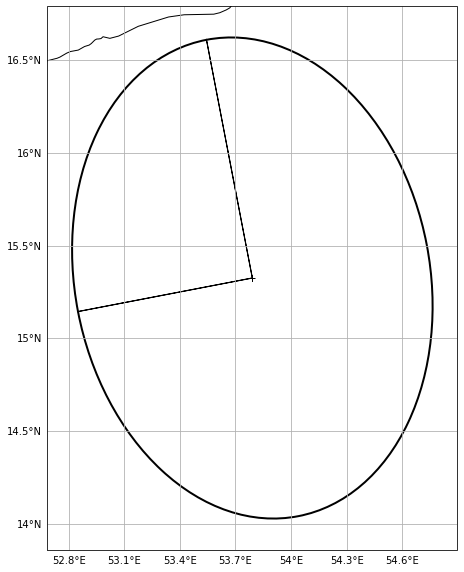

In [6]:
eddy=get_eddy(observation,0)

plt.rcParams['figure.figsize'] = 10, 10
figure=StreamPlot()
figure.plot_eddies([eddy])
figure.show()

In [7]:
R=np.eye(6)/1000 #covariance of observation noise

In [8]:
prediction=predict_eddy(eddy,catalog,observation,R=R)

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 529.20it/s]


## Results

Prediction t=0


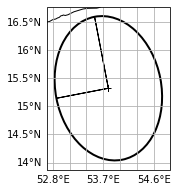

Prediction t=1


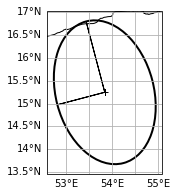

Prediction t=2


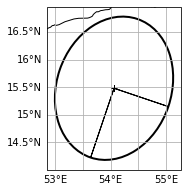

Prediction t=3


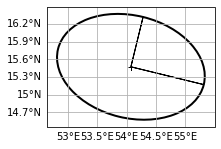

Prediction t=4


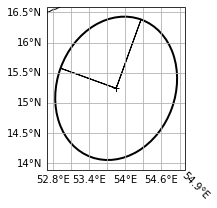

Prediction t=5


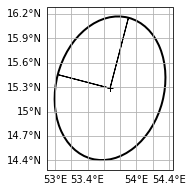

Prediction t=6


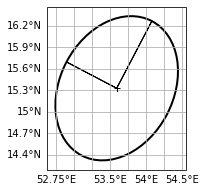

Prediction t=7


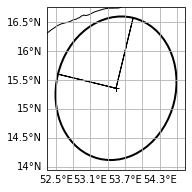

Prediction t=8


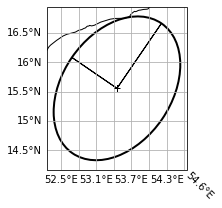

Prediction t=9


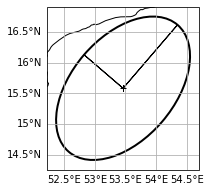

Prediction t=10


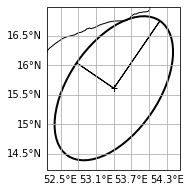

Prediction t=11


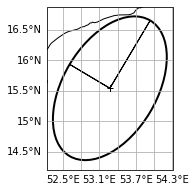

Prediction t=12


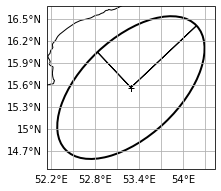

Prediction t=13


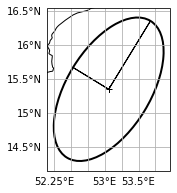

Prediction t=14


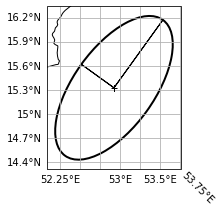

Prediction t=15


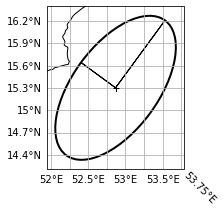

Prediction t=16


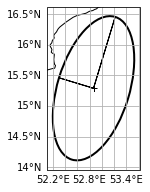

Prediction t=17


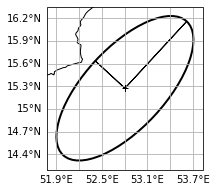

Prediction t=18


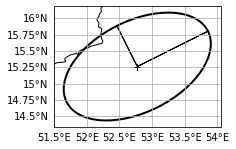

In [9]:
plt.rcParams['figure.figsize'] = 3, 3
for t in prediction.time:
    i=t-present_time
    eddy=get_eddy(prediction,i)
    print("Prediction t=%s"%i)
    figure=StreamPlot()
    figure.plot_eddies([eddy])
    figure.show()

We can look it parameter by parameter. For example, let focus on the first axe of the ellipse.

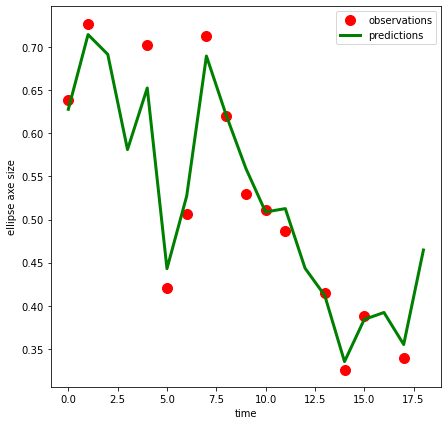

In [10]:
plt.rcParams['figure.figsize'] = 7, 7
plt.plot(observation.values[:,2],'or',markersize=10,label="observations")
plt.plot(prediction.values[:,2],'-g',linewidth=3,label="predictions")
plt.xlabel("time"),plt.ylabel("ellipse axe size"),plt.legend()
plt.show()